# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
%load_ext autoreload
%autoreload 2
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

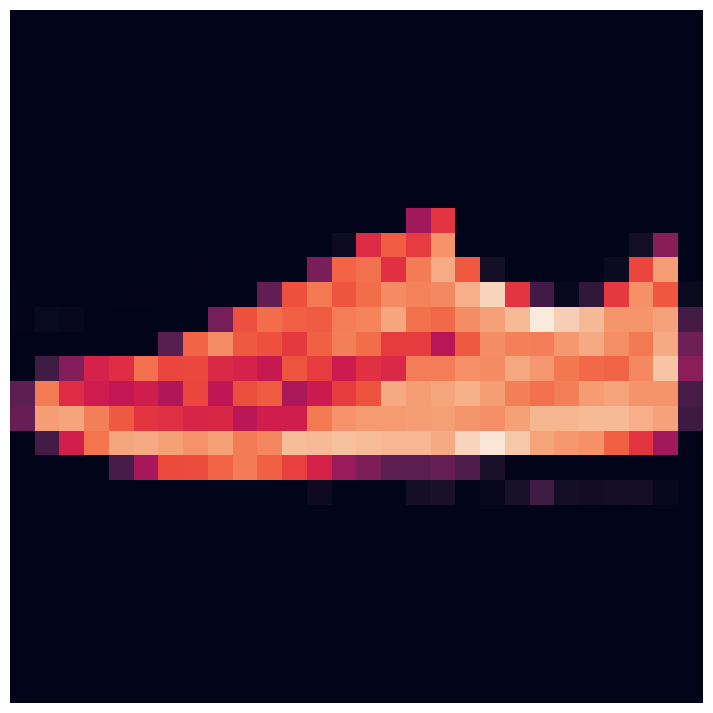

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

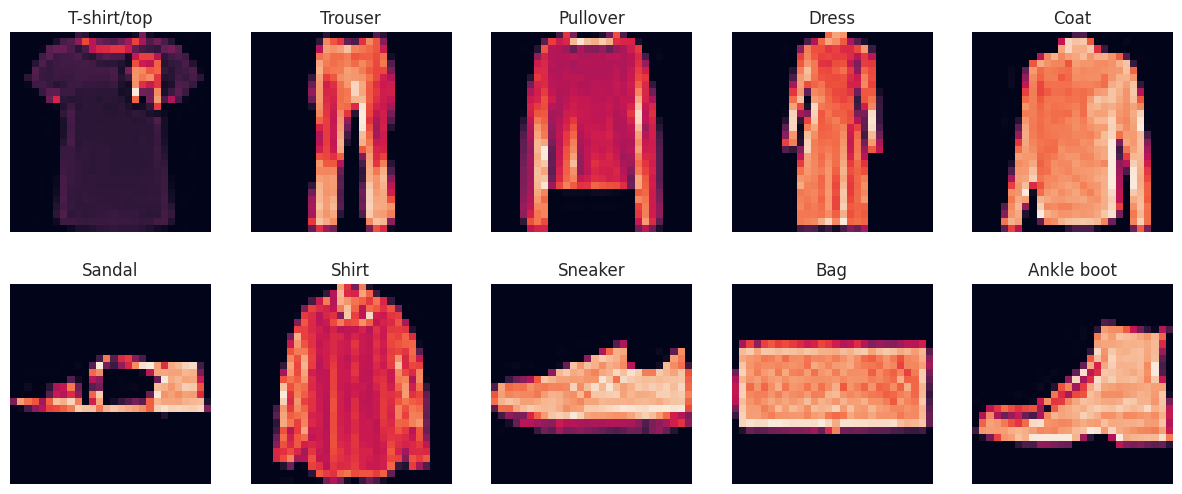

In [6]:
# Convert labels to integer type
y = y.astype(int)

class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
#print(np.where(y=='1')[0][0])
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    class_indices = np.where(y == i)[0]
    sample_index = class_indices[0]
    sample_image = X[sample_index]
    ax.imshow(sample_image.reshape(28, 28, 1))
    ax.set_title(class_labels[i])
    ax.axis('off')

plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

Dataset shape: (1000, 784)
Dataset data type: int64


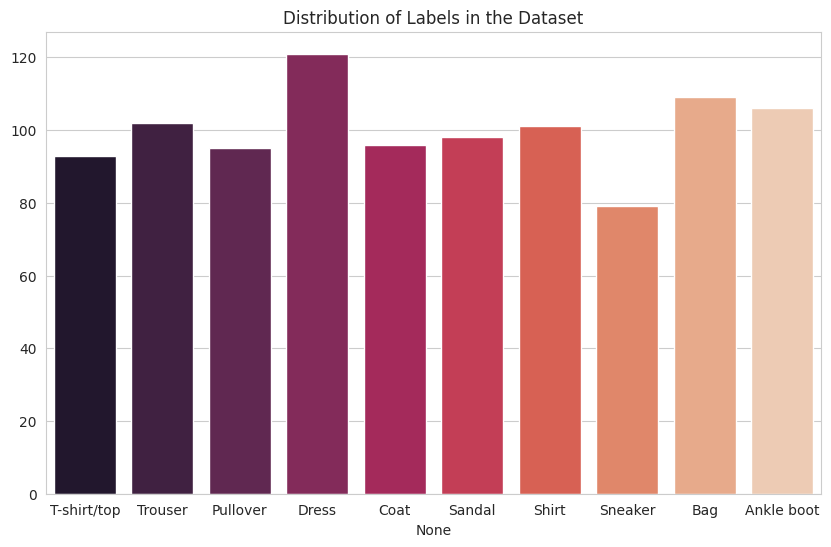

T-shirt/top     93
Trouser        102
Pullover        95
Dress          121
Coat            96
Sandal          98
Shirt          101
Sneaker         79
Bag            109
Ankle boot     106
Name: count, dtype: int64


In [7]:
# Check the shape and type of dataset
print("Dataset shape:", X.shape)
print("Dataset data type:", X.dtype)

# Check the distribution of labels
label_counts = pd.Series(y).value_counts().sort_index()
label_counts.index = ["T-shirt/top", "Trouser", "Pullover", 
                      "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag","Ankle boot"]
plt.figure(figsize=(10, 6))
palette = sns.color_palette("rocket", 10)
sns.barplot(x=label_counts.index, y=label_counts.values, hue = label_counts.index, palette = palette)

plt.title('Distribution of Labels in the Dataset')
plt.show()
print(label_counts)

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15,
                                                    random_state=SEED)
print(np.shape(X_train),np.shape(X_test))

(850, 784) (150, 784)


### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [9]:
# Filter the training data to include only samples with labels 0 and 1
binary_train_X = X_train[(y_train == 0) | (y_train == 1)]
binary_train_y = y_train[(y_train == 0) | (y_train == 1)]

# Filter the test data to include only samples with labels 0 and 1
binary_test_X = X_test[(y_test == 0) | (y_test == 1)]
binary_test_y = y_test[(y_test == 0) | (y_test == 1)]
np.shape(binary_test_X)

(28, 784)

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [10]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [11]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [12]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [14]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

26.3 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.25 ms ± 527 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса

In [15]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)
print(binary_test_y)

[1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 1.]
[1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1]


In [16]:
#knn_classifier = KNNClassifier(k=100)
#knn_classifier.fit(binary_train_X, binary_train_y)
#prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [17]:
# TODO: binary_classification_metrics in metrics.py

In [18]:
binary_classification_metrics(prediction, binary_test_y)

(0.9999999999411765, 0.9999999999411765, 0.9999999994411766, 1.0)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_classification_metrics(y_pred, y_true):
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    f1 = f1_score(y_pred, y_true)
    accuracy = accuracy_score(y_pred, y_true)
    return precision, recall, f1, accuracy

calculate_classification_metrics(prediction, binary_test_y)

(1.0, 1.0, 1.0, 1.0)

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [20]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        prediction_train = knn_classifier.predict(X_train)
        prediction_test = knn_classifier.predict(X_test)
        if metric == 'precision_score':
            train_metrics.append(binary_classification_metrics(prediction_train, y_train)[0])
            test_metrics.append(binary_classification_metrics(prediction_test, y_test)[0])
        elif metric == 'recall_score':
            train_metrics.append(binary_classification_metrics(prediction_train, y_train)[1])
            test_metrics.append(binary_classification_metrics(prediction_test, y_test)[1])
        elif metric == 'f1_score':
            train_metrics.append(binary_classification_metrics(prediction_train, y_train)[2])
            test_metrics.append(binary_classification_metrics(prediction_test, y_test)[2])
        else:
            train_metrics.append(binary_classification_metrics(prediction_train, y_train)[3])
            test_metrics.append(binary_classification_metrics(prediction_test, y_test)[3])
    return train_metrics, test_metrics

In [21]:
params = [1, 2, 4, 5, 8, 10, 30] #[i for i in range(1,1000,5)]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, 
                                          binary_test_X, binary_test_y, params, precision_score)
print(train_metrics, test_metrics)

[1.0, 1.0, 0.9940119760479041, 0.9940119760479041, 0.9820359281437125, 0.9820359281437125, 0.9520958083832335] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


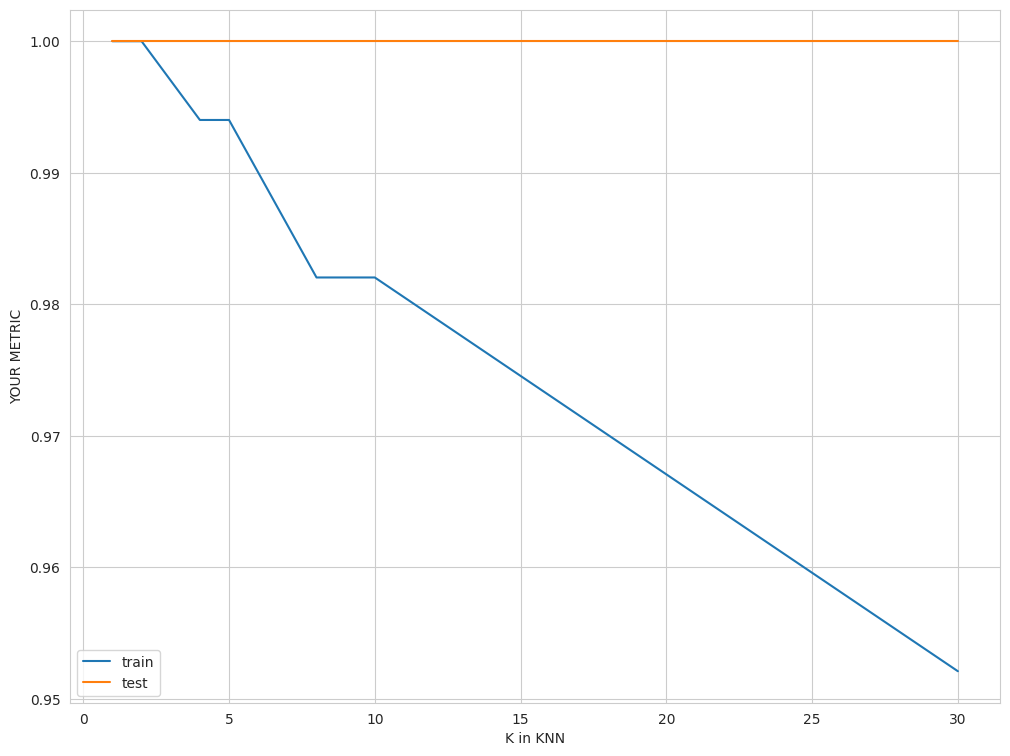

In [22]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

In [23]:
params = [i for i in range(1,500,5)]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, 
                                          binary_test_X, binary_test_y, params, precision_score)

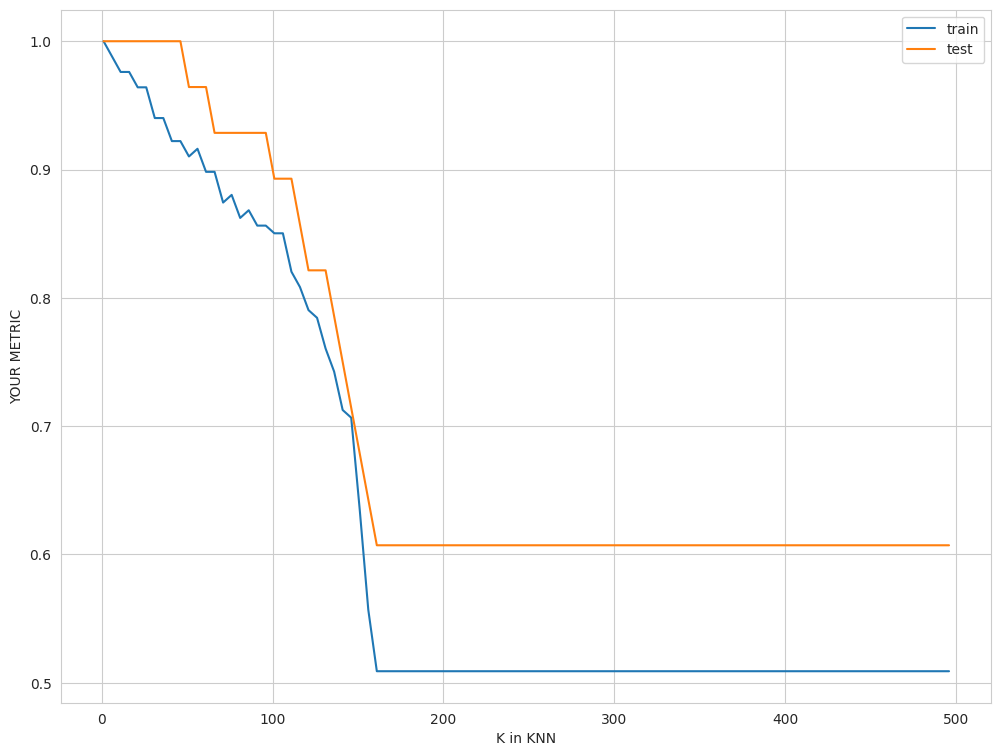

In [24]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

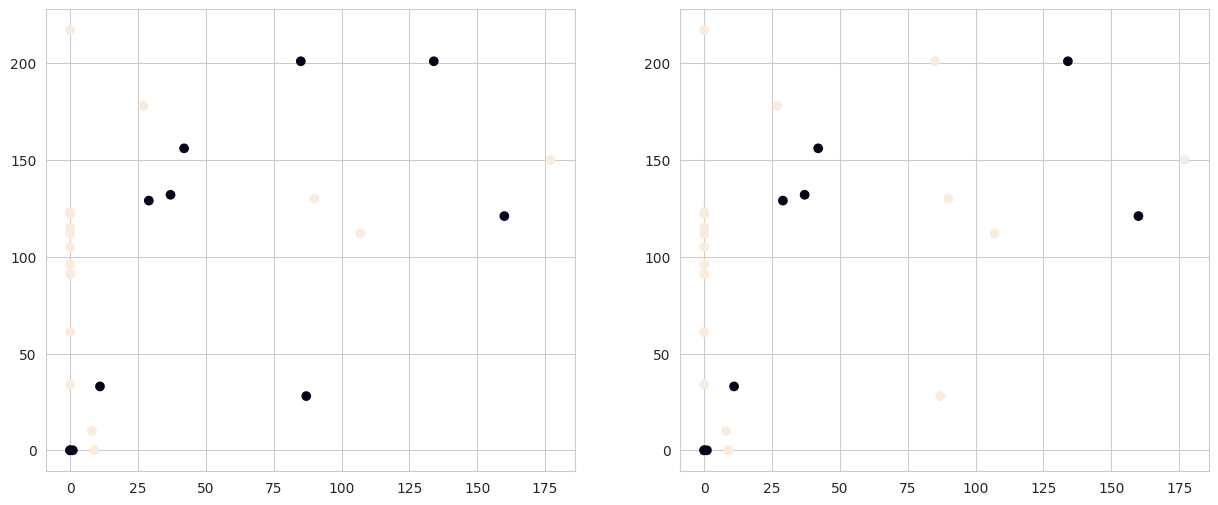

In [25]:
knn_classifier = KNNClassifier(k=100)
knn_classifier.fit(binary_train_X, binary_train_y)
prediction_test = knn_classifier.predict(binary_test_X)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(binary_test_X[:,9],binary_test_X[:,10], c = binary_test_y)
axes[1].scatter(binary_test_X[:,9],binary_test_X[:,10], c = prediction_test);

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [26]:
# TODO: predict_labels_multiclass in knn.py
#The KNN.ipynb kernel died with standard parameters. The amount of data in the dataset has been reduced 
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=300)
X = X[idx_to_stay]
y = y[idx_to_stay]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1,
                                                    random_state=SEED)
print(np.shape(X_train),np.shape(X_test))

knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
predictions

(270, 784) (30, 784)


array([8., 9., 1., 0., 3., 7., 1., 3., 9., 6., 9., 1., 6., 2., 2., 6., 6.,
       5., 6., 0., 4., 6., 2., 6., 8., 6., 0., 0., 1., 3.])

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [27]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

(0.745833332953993, 0.669999999701, 0.7058858143509975, 0.6666666666666666)

In [28]:
params = [1, 2, 4, 5, 8, 10, 30] 
train_metrics, test_metrics = find_best_k(X_train, y_train, 
                                          X_test, y_test, params, accuracy_score)
print(train_metrics, test_metrics)

[1.0, 0.9814814814814815, 1.0, 1.0, 0.9574468085106383, 0.9787234042553191, 0.9767441860465116] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875]


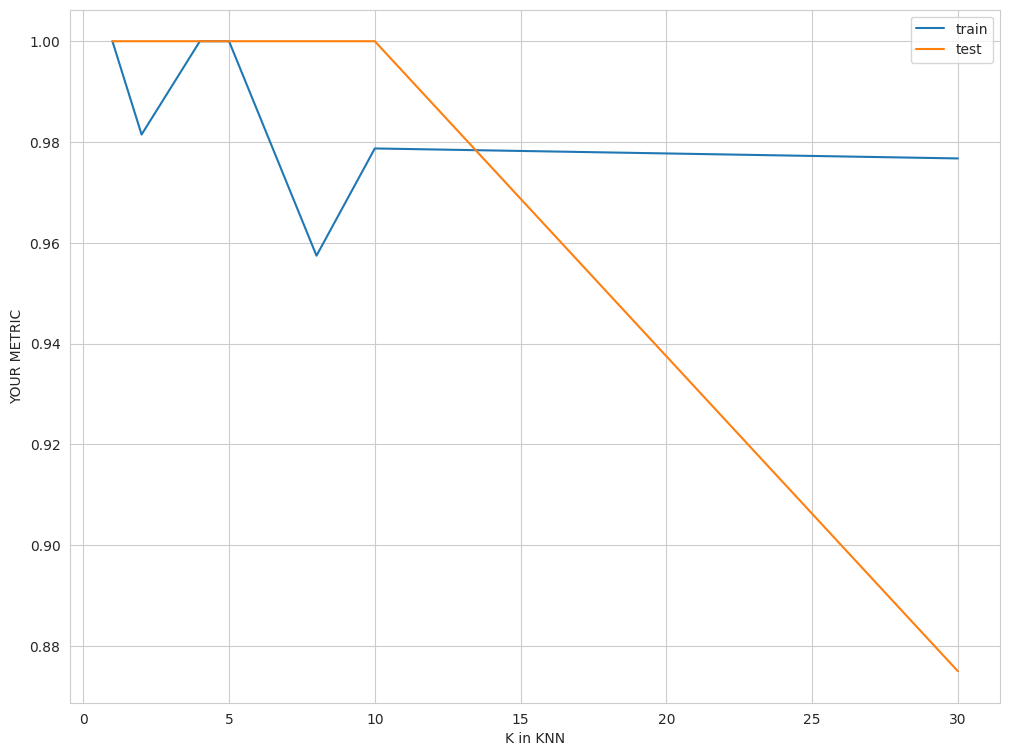

In [29]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

**n_neighbors = 5** is optimal value

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [30]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [31]:
X, y = load_diabetes(as_frame=True, return_X_y=True, scaled = False)

In [32]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [33]:
from sklearn.pipeline import Pipeline

In [34]:
# EDA
diabetes = load_diabetes(scaled = False)
diabetes_df = pd.DataFrame(data=np.c_[diabetes['data'], diabetes['target']], columns=diabetes['feature_names'] + ['target'])
display(diabetes_df.head())
display(diabetes_df.info())
display(diabetes_df.describe())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


None

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


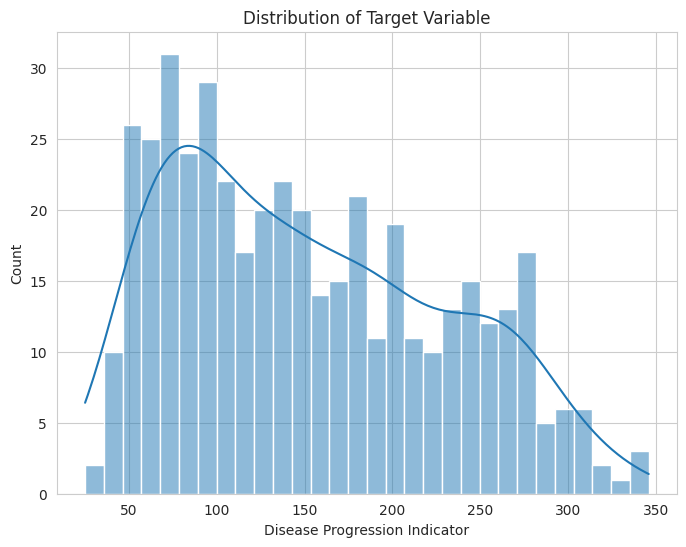

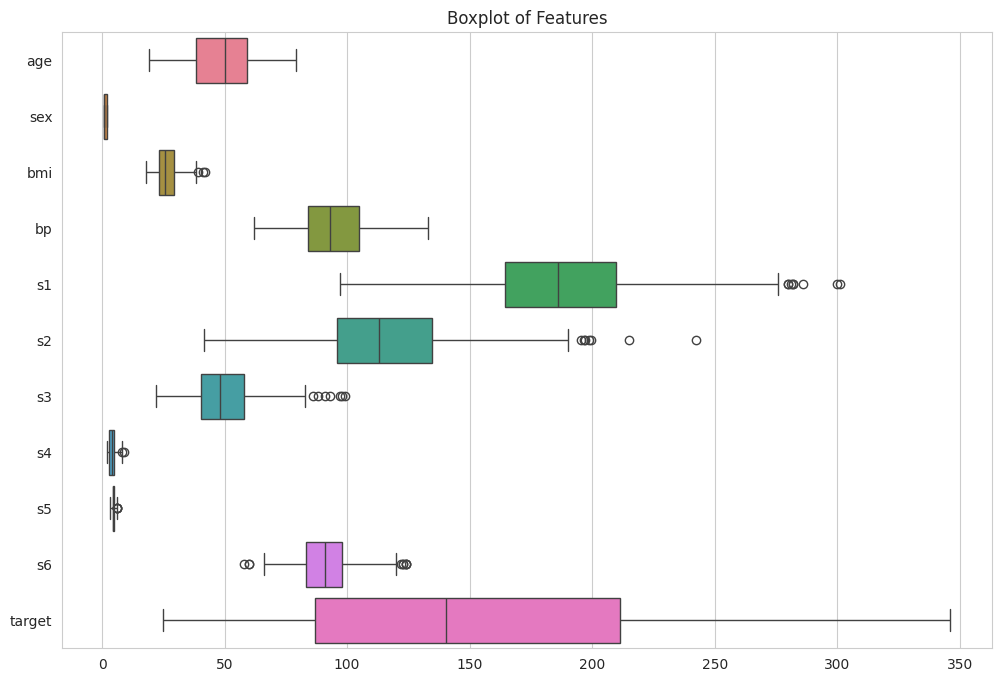

In [35]:
# Histogram of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(diabetes_df['target'], kde=True, bins=30)
plt.xlabel('Disease Progression Indicator')
plt.title('Distribution of Target Variable')
plt.show()

# Boxplot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=diabetes_df, orient='h')
plt.title('Boxplot of Features')
plt.show()

The shape of the histogram indicate the skewness of the target variable distribution. A skewed distribution could suggest a bias towards certain values (50-150). 

Also we need to standardize data.

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15,
                                                    random_state=SEED)
# Create a pipeline with StandardScaler and KNeighborsRegressor
cat_cols = ["sex"]
num_cols = ["age",	"bmi",
            "bp",	"s1",	"s2",
            "s3",	"s4",
            "s5",	"s6"]

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsRegressor(n_neighbors=10))  # Assuming 5 neighbors
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing data
y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [37]:
# TODO: r_squared, mse, mae in metrics.py
from metrics import r_squared, mse, mae
# Calculating R-squared
r2 = r_squared(y_pred, y_test)
r2_train = r_squared(y_pred_train, y_train)
print('R-squared:', r2, r2_train)

# Calculating mean squared error
mse_value = mse(y_pred, y_test)
mse_value_train = mse(y_pred_train, y_train)

print('Mean Squared Error:', mse_value, mse_value_train)

# Calculating mean absolute error
mae_value = mae(y_pred, y_test)
mae_value_train = mae(y_pred_train, y_train)
print('Mean Absolute Error:', mae_value, mae_value_train)

R-squared: 0.4123684423879871 0.5442966825789639
Mean Squared Error: 3029.0389552238807 2763.11376
Mean Absolute Error: 44.01641791044776 41.9824


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [38]:
k_neighbors = [1, 2, 3, 5, 7, 10, 30, 50]
r2_scores_test = []
r2_scores_train = []
mse_scores_test = []
mse_scores_train = []
mae_scores_test = []
mae_scores_train = []

for k in k_neighbors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('knn_regressor', KNeighborsRegressor(n_neighbors=k))  # Assuming 5 neighbors
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    
    y_pred_train = pipeline.predict(X_train)
    
    r2_scores_test.append(r_squared(y_pred, y_test))
    r2_scores_train.append(r_squared(y_pred_train, y_train))
    mse_scores_test.append(mse(y_pred, y_test))
    mse_scores_train.append(mse(y_pred, y_test))
    mae_scores_test.append(mae(y_pred, y_test))
    mae_scores_train.append(mae(y_pred, y_test))

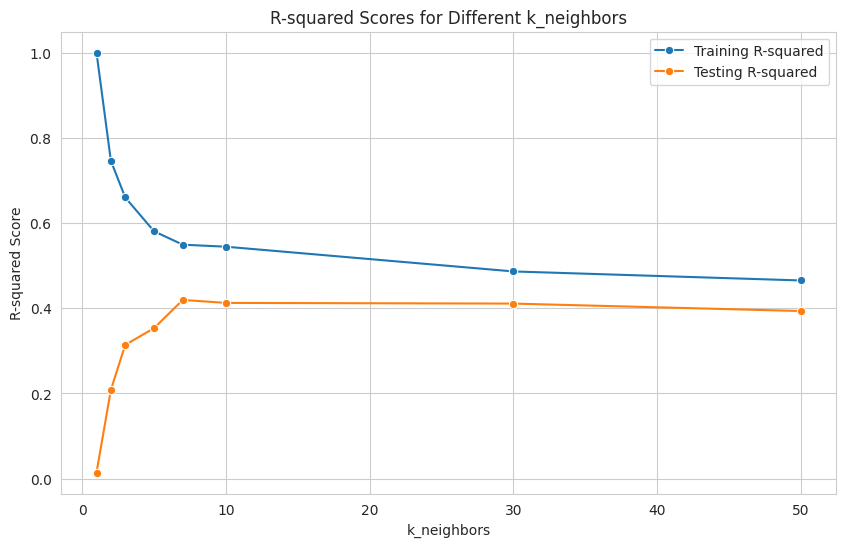

In [39]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_neighbors, y=r2_scores_train, marker='o', label='Training R-squared')
sns.lineplot(x=k_neighbors, y=r2_scores_test, marker='o', label='Testing R-squared')
plt.title('R-squared Scores for Different k_neighbors')
plt.xlabel('k_neighbors')
plt.ylabel('R-squared Score')
plt.legend()
plt.show()

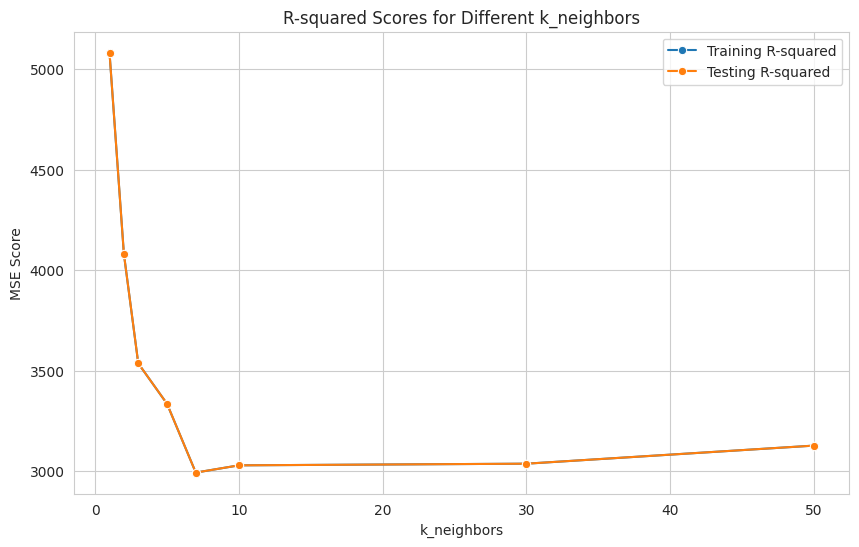

In [40]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_neighbors, y=mse_scores_test, marker='o', label='Training R-squared')
sns.lineplot(x=k_neighbors, y=mse_scores_train, marker='o', label='Testing R-squared')
plt.title('R-squared Scores for Different k_neighbors')
plt.xlabel('k_neighbors')
plt.ylabel('MSE Score')
plt.legend()
plt.show()

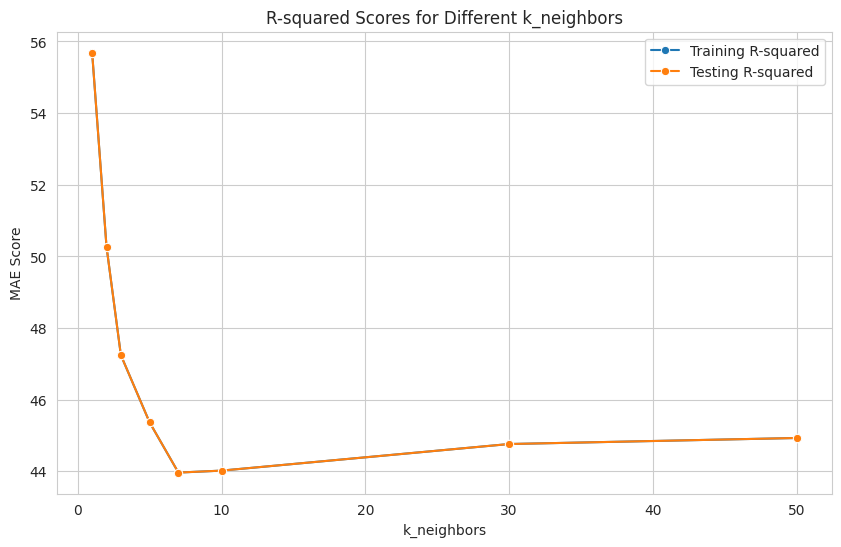

In [41]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_neighbors, y=mae_scores_test, marker='o', label='Training R-squared')
sns.lineplot(x=k_neighbors, y=mae_scores_train, marker='o', label='Testing R-squared')
plt.title('R-squared Scores for Different k_neighbors')
plt.xlabel('k_neighbors')
plt.ylabel('MAE Score')
plt.legend()
plt.show()

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

**n_neighbors = 5** is optimal value

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

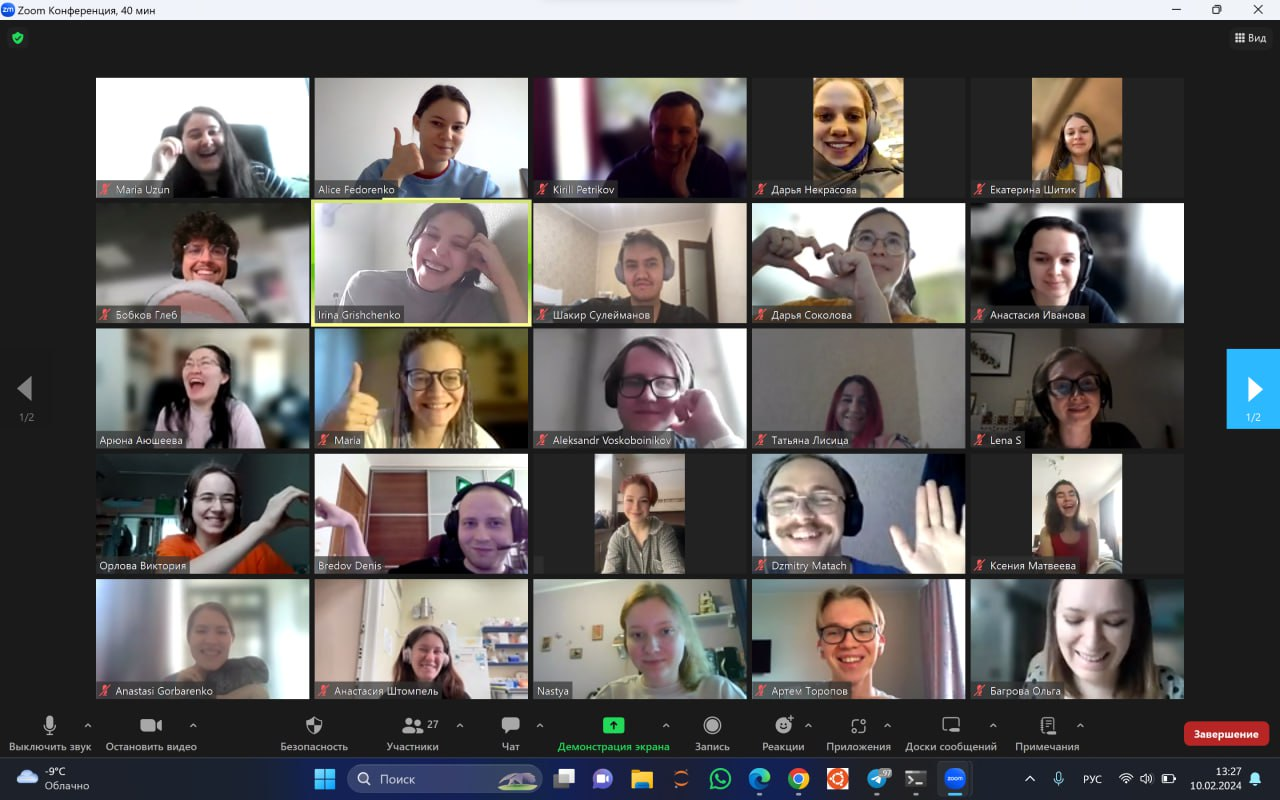

In [42]:
from IPython.display import Image
Image(filename = 'photo_5348314159013549455_y.jpg', width=500, height=500)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**
Было непросто, хотелось немножко поплакать, но очень интересно

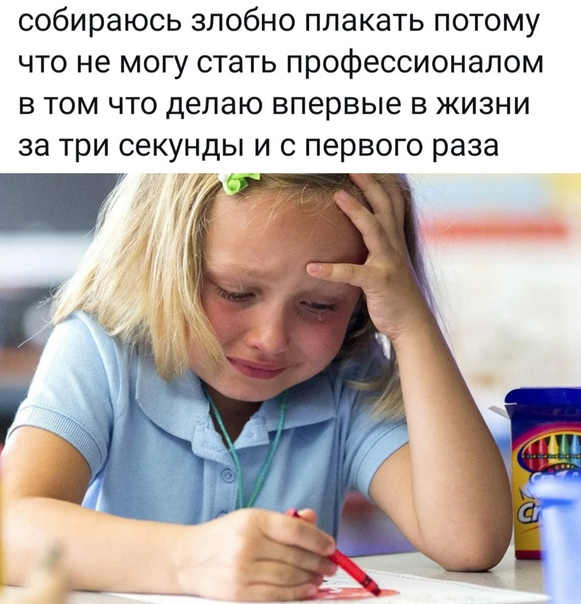

In [43]:
Image(filename = 'ETeiW14WrJY.jpg', width=500, height=500)